In [4]:
!nvidia-smi

Tue Jun 18 14:52:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              16W /  72W |    118MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 0. 라이브러리

In [5]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

import transformers
from transformers import AutoTokenizer, AutoModel, GPT2ForSequenceClassification, get_linear_schedule_with_warmup

from peft import get_peft_model, LoraConfig, TaskType

In [6]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    transformers.set_seed(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
fixSEED(seed=SEED)

2024-06-18 14:52:15.059094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 14:52:15.061846: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 14:52:15.117707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 14:52:15.823496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print('Current path {}'.format(os.getcwd()))

Current path /home/leesanghyuk2000/Python_Programs


In [8]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def checkGPU(empty=False):
    if torch.cuda.is_available():
        total_mem = torch.cuda.get_device_properties(0).total_memory
        current_mem = torch.cuda.memory_allocated(0)
        free_mem = total_mem - current_mem
        
        print(f'남은 GPU 메모리: {free_mem / (1024 ** 3):.2f} GB')
        
        if empty:
            torch.cuda.empty_cache()
            after_mem = torch.cuda.memory_allocated(0)
            print(f'GPU 캐시에서 메모리 삭제 후 메모리: {after_mem / (1024 ** 3):.2f} GB')
    else:
        print('CUDA 사용 불가')

### 1. 데이터 불러오기

In [11]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb") as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data

In [12]:
aihub_data = callData('AiHub_Sampled(2000).pkl')

레이블 0 개수 : 990
레이블 1 개수 : 992


In [13]:
youtube_data = callData('youtubeData(8331)_with_label.pkl')

레이블 0 개수 : 5208
레이블 1 개수 : 3123


In [14]:
# concat two data
text1 = aihub_data['newsContent'] # 제목 미포함
text2 = youtube_data['content'] # 제목 미포함

label1 = aihub_data['label']
label2 = youtube_data['label']

data = pd.DataFrame({
    'text': pd.concat([text1, text2], ignore_index=True),
    'label': pd.concat([label1, label2], ignore_index=True)
})

In [16]:
# 레이블 확인
data['label'].value_counts()

label
0    6198
1    4115
Name: count, dtype: int64

### 2. Train/Test/Valid

In [17]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify=train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [18]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 6187개 
검증용 데이터 개수 : 2063개 
평가용 데이터 개수 : 2063개


### 3. Dataset 및 Dataloader 정의

In [19]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [20]:
# Mixed Dataset for GPT2 Classification
class GPT2Dataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        
        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. GPT2 Model

In [34]:
class BaitingDetectGPT2(nn.Module):
    def __init__(self, model_checkpoint, lora_r=16, lora_alpha=1, lora_dropout=0.1, num_labels=2):
        super(BaitingDetectGPT2, self).__init__()
        self.num_labels = num_labels
        
        # Pre-trained GPT-2 layer
        self.model = GPT2ForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels) # Automodel은 labels 인자가 없다는 에러로 인해 seq clf로 변경
        
        # LoRA configuration for GPT-2 layer
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            #target_modules=["query", 'key', "value"],
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )
        self.model = get_peft_model(self.model, lora_config)
        
        # Dropout
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
        output = self.dropout(output)
        
        return output

### 5. 학습용 Trainer 정의

In [23]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

        # 스케줄러 초기화
        total_steps = len(train_dataloader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 100)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 100)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'▶️ Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./YouTube(mixed)_GPT2_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'▶️ Model Saved to {save_path}')
                except Exception as e:
                    print(f'▶️ Model Not Saved: {e}')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'▶️▶️▶️ Early Stopping at Epoch {epoch+1} ◀️◀️◀️')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, y = batch
            input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()  # 스케줄러 업데이트

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, y = batch
                input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)

### 6. 학습 진행

In [24]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 64

model_checkpoint = 'skt/kogpt2-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                          bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                          pad_token='<pad>', mask_token='<mask>')

In [25]:
# 데이터셋 정의
train_dataset = GPT2Dataset(train_data, tokenizer, max_length)
valid_dataset = GPT2Dataset(valid_data, tokenizer, max_length)
test_dataset = GPT2Dataset(test_data, tokenizer, max_length)

In [26]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[44362,  9651,  6872,  ...,  9080,  9723,  7098],
         [42915,  8452,  9023,  ..., 27873,  9426,  9518],
         [ 9528, 18354, 10135,  ...,  9947,  9065, 10605],
         ...,
         [ 9141,  8031,  9028,  ...,  9651,  7080,  7162],
         [25906,  8702,  7801,  ...,  7714,  8715,  8146],
         [ 9490, 18937, 21190,  ...,  9226, 19077,  7416]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
         1, 1, 0, 1, 0, 1, 0, 1])]

In [35]:
# Model
model = BaitingDetectGPT2(model_checkpoint)
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BaitingDetectGPT2(
  (model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): GPT2ForSequenceClassification(
        (transformer): GPT2Model(
          (wte): Embedding(51200, 768)
          (wpe): Embedding(1024, 768)
          (drop): Dropout(p=0.1, inplace=False)
          (h): ModuleList(
            (0-11): 12 x GPT2Block(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): GPT2Attention(
                (c_attn): lora.Linear(
                  (base_layer): Conv1D()
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2304, bias=False)
                  )
                  (lora_embe

In [36]:
print_trainable_parameters(model)

Trainable Params: 591360 
All params: 125756928
--------------------------------------------------
Trainable(%): 0.47024


In [41]:
# 학습 파라미터
num_epochs = 10
wait_for_es = 5

learning_rate = 2e-5
wd_rate = 3e-3
eps_rate = 1e-8

In [42]:
# 손실함수, 옵티마이저, Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=wd_rate, eps=eps_rate)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [43]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [44]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

----------------------------------------------------------------------------------------------------
Epoch 1/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


[Train] 	 Loss: 0.7956 	 Acc: 0.5677 	 Precision: 0.4509 	 Recall: 0.3834 	 F1: 0.4048
[Valid] 	 Loss: 0.7273 	 Acc: 0.5925 	 Precision: 0.4783 	 Recall: 0.4068 	 F1: 0.4315
▶️ Epoch 1 complete in 1m 6s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.5925.pth
----------------------------------------------------------------------------------------------------
Epoch 2/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]


[Train] 	 Loss: 0.6794 	 Acc: 0.6345 	 Precision: 0.5498 	 Recall: 0.4659 	 F1: 0.4918
[Valid] 	 Loss: 0.6454 	 Acc: 0.6440 	 Precision: 0.5656 	 Recall: 0.4612 	 F1: 0.4972
▶️ Epoch 2 complete in 2m 13s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.6440.pth
----------------------------------------------------------------------------------------------------
Epoch 3/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.73it/s]


[Train] 	 Loss: 0.6122 	 Acc: 0.6753 	 Precision: 0.6063 	 Recall: 0.5163 	 F1: 0.5481
[Valid] 	 Loss: 0.5951 	 Acc: 0.6763 	 Precision: 0.6096 	 Recall: 0.5343 	 F1: 0.5604
▶️ Epoch 3 complete in 3m 20s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.6763.pth
----------------------------------------------------------------------------------------------------
Epoch 4/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.76it/s]


[Train] 	 Loss: 0.5714 	 Acc: 0.7040 	 Precision: 0.6412 	 Recall: 0.5967 	 F1: 0.6065
[Valid] 	 Loss: 0.5634 	 Acc: 0.7030 	 Precision: 0.6415 	 Recall: 0.5985 	 F1: 0.6102
▶️ Epoch 4 complete in 4m 27s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7030.pth
----------------------------------------------------------------------------------------------------
Epoch 5/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.83it/s]


[Train] 	 Loss: 0.5352 	 Acc: 0.7315 	 Precision: 0.6775 	 Recall: 0.6331 	 F1: 0.6447
[Valid] 	 Loss: 0.5425 	 Acc: 0.7176 	 Precision: 0.6485 	 Recall: 0.6401 	 F1: 0.6301
▶️ Epoch 5 complete in 5m 35s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7176.pth
----------------------------------------------------------------------------------------------------
Epoch 6/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


[Train] 	 Loss: 0.5184 	 Acc: 0.7383 	 Precision: 0.6782 	 Recall: 0.6581 	 F1: 0.6595
[Valid] 	 Loss: 0.5294 	 Acc: 0.7277 	 Precision: 0.6598 	 Recall: 0.6522 	 F1: 0.6486
▶️ Epoch 6 complete in 6m 41s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7277.pth
----------------------------------------------------------------------------------------------------
Epoch 7/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:13<00:00,  4.81it/s]


[Train] 	 Loss: 0.5063 	 Acc: 0.7441 	 Precision: 0.6871 	 Recall: 0.6730 	 F1: 0.6692
[Valid] 	 Loss: 0.5207 	 Acc: 0.7309 	 Precision: 0.6674 	 Recall: 0.6467 	 F1: 0.6499
▶️ Epoch 7 complete in 7m 48s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7309.pth
----------------------------------------------------------------------------------------------------
Epoch 8/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


[Train] 	 Loss: 0.4910 	 Acc: 0.7586 	 Precision: 0.6972 	 Recall: 0.6876 	 F1: 0.6824
[Valid] 	 Loss: 0.5155 	 Acc: 0.7353 	 Precision: 0.6723 	 Recall: 0.6659 	 F1: 0.6606
▶️ Epoch 8 complete in 8m 54s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7353.pth
----------------------------------------------------------------------------------------------------
Epoch 9/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


[Train] 	 Loss: 0.4888 	 Acc: 0.7600 	 Precision: 0.7005 	 Recall: 0.6973 	 F1: 0.6905
[Valid] 	 Loss: 0.5118 	 Acc: 0.7367 	 Precision: 0.6717 	 Recall: 0.6727 	 F1: 0.6612
▶️ Epoch 9 complete in 9m 59s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7367.pth
----------------------------------------------------------------------------------------------------
Epoch 10/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


[Train] 	 Loss: 0.4889 	 Acc: 0.7605 	 Precision: 0.7001 	 Recall: 0.7010 	 F1: 0.6938
[Valid] 	 Loss: 0.5097 	 Acc: 0.7376 	 Precision: 0.6689 	 Recall: 0.6605 	 F1: 0.6578
▶️ Epoch 10 complete in 11m 4s
▶️ Model Saved to ./YouTube(mixed)_GPT2_ACC_0.7376.pth


In [45]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    fig = plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

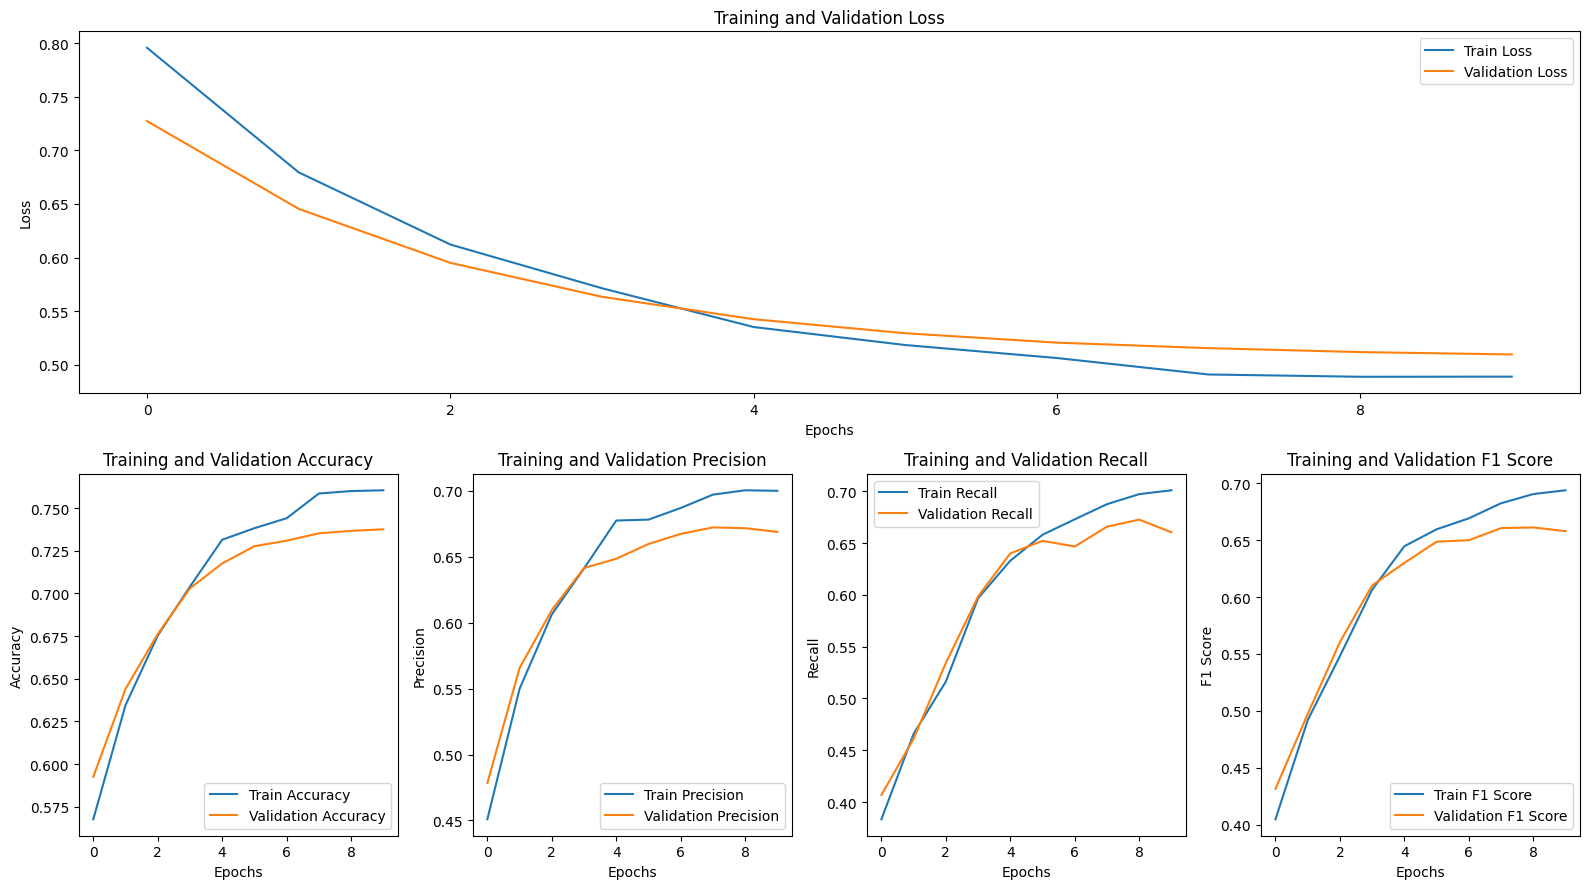

In [46]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

### 7. 평가

In [47]:
# 모델 로드 함수 정의
def load_model(model_path, model_checkpoint):
    model = BaitingDetectGPT2(model_checkpoint)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [50]:
# 저장된 모델 경로
best_model_path = path+'/YouTube(mixed)_GPT2_ACC_0.7376.pth'

In [51]:
# 모델 불러오기
model = load_model(best_model_path, model_checkpoint)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 65/65 [00:11<00:00,  5.43it/s]


In [53]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_precision = precision_score(true_labels, preds_list)
test_recall = recall_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)
test_cm = confusion_matrix(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix: \n{test_cm}')

Test Accuracy: 0.7693
Test Precision: 0.7227
Test Recall: 0.6841
Test F1 Score: 0.7029
Test Confusion Matrix: 
[[1024  216]
 [ 260  563]]


### Note

- GPT2 기반의 이진분류의 성능은 그다지 좋지 않다. (구조적 한계라고 생각)
- 혼동행렬을 확인하면 실제는 0인데 1이라고 예측한 경우(FP)보다 실제는 1인데 0이라고 예측한 경우(FN)가 많다. (반대의 상황은 바람직하지 못함)
- RoBERTa에 비해 LoRA scaling factor가 큰데도 Inference 속도가 빠름(👍)
- RoBERTa에 비해 LoRA scaling factor가 큰데도 Inference 정확도가 낮음(👎)

### 모델 수정 참고

- GPT2 이진분류 모델 참고: https://dacon.io/en/codeshare/9142?page&dtype&ptype&fType&category
- SKT/KoGPT-2 깃허브 : https://github.com/SKT-AI/KoGPT2
- SKT/KoGPT-2 파인튜닝 예시 :  https://github.com/seawavve/newsTopicClassification/blob/main/NewsTopicClassificationwithKoGPT2.ipynb
- ```GPT2Model```과 ```GPT2ForSequenceClassification``` 선택 근거 :  [OpenAI GPT2 Official Blog](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Model)
- ```forward()``` has no ```labels``` : https://discuss.huggingface.co/t/typeerror-forward-got-an-unexpected-keyword-argument-labels/14377/4